Example notebook training a flow on samples

In [1]:
import os
import sys
import argparse
import torch
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from getdist import plots, MCSamples
import getdist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from scipy.stats import multivariate_normal

In [2]:
path = os.path.realpath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, path)

In [3]:
from nnest.trainer import Trainer
from nnest.likelihoods import *
from nnest.priors import *
from nnest.distributions import GeneralisedNormal

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
def plot_flow(samples, model):
    x_synth = model.netG.sample(samples.size).detach().cpu().numpy()
    z = model.get_latent_samples(samples)
    grid = []
    for x in np.linspace(np.min(samples[:, 0]) - 1, np.max(samples[:, 0]) + 1, 10):
        for y in np.linspace(np.min(samples[:, 1]) - 1, np.max(samples[:, 1]) + 1, 5000):
            grid.append([x, y])
    for y in np.linspace(np.min(samples[:, 1]) - 1, np.max(samples[:, 1]) + 1, 10):
        for x in np.linspace(np.min(samples[:, 0]) - 1, np.max(samples[:, 0]) + 1, 5000):
            grid.append([x, y])
    grid = np.array(grid)
    z_grid = model.get_latent_samples(grid)
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    ax[0].scatter(grid[:, 0], grid[:, 1], c=grid[:, 0], marker='.', s=1, linewidths=0)
    ax[0].scatter(samples[:, 0], samples[:, 1], s=4)
    ax[0].set_title('Real data')
    ax[1].scatter(z_grid[:, 0], z_grid[:, 1], c=grid[:, 0], marker='.', s=1, linewidths=0)
    ax[1].scatter(z[:, 0], z[:, 1], s=4)
    ax[1].set_title('Latent data')
    ax[2].scatter(x_synth[:, 0], x_synth[:, 1], s=2)
    ax[2].set_title('Synthetic data')
    plt.tight_layout()
    plt.show()
    # Plot grid warp
    plt.figure(figsize=(6,6))
    ng = 30
    xx, yy = np.linspace(-4,4, ng), np.linspace(-4,4, ng)
    xv, yv = np.meshgrid(xx, yy)
    xy = np.stack([xv, yv], axis=-1)
    in_circle = np.sqrt((xy**2).sum(axis=2)) <= 3
    xy = xy.reshape((ng*ng, 2))
    xy = torch.from_numpy(xy.astype(np.float32))
    xs = model.get_samples(xy)
    xs = xs.reshape((ng, ng, 2))
    p1 = np.reshape(xs[1:,:,:], (ng**2-ng,2))
    p2 = np.reshape(xs[:-1,:,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    p1 = np.reshape(xs[:,1:,:], (ng**2-ng,2))
    p2 = np.reshape(xs[:,:-1,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    plt.gca().add_collection(lcy)
    plt.gca().add_collection(lcx)
    plt.xlim([np.min(samples[:,0])-0.05,np.max(samples[:,0])+0.05])
    plt.ylim([np.min(samples[:,1])-0.05,np.max(samples[:,1])+0.05])
    plt.scatter(samples[:,0], samples[:,1], c='r', s=5, alpha=0.5)
    plt.show()

In [6]:
# Likelihood
#like = Himmelblau(2)
#prior = UniformPrior(2, -5, 5)
#like = Rosenbrock(2)
#prior = UniformPrior(2, -2, 12)
#like = Gaussian(2, 0.9)
#prior = UniformPrior(2, -5, 5)
#like = Eggbox(2)
#prior = UniformPrior(2, -15, 15)
#like = GaussianShell(2)
#prior = UniformPrior(2, -3, 3)
#like = GaussianMix(2)
#prior = UniformPrior(2, -8, 8)
prior = UniformPrior(2, [-7, -3], [7, 3])
like = DoubleGaussianShell(2, centers=[[-4.0, 0.0], [4.0, 0.0]])

In [7]:
np.random.seed(0)
samples = like.sample(prior, 1000)

In [8]:
#base_dist = TransformedDistribution(Uniform(torch.zeros(like.x_dim), torch.ones(like.x_dim)), SigmoidTransform().inv)
base_dist = MultivariateNormal(torch.zeros(like.x_dim), torch.eye(like.x_dim))
#base_dist = GeneralisedNormal(torch.zeros(like.x_dim), torch.ones(like.x_dim), torch.tensor(8.0))

In [9]:
#t = Trainer(like.x_dim, flow='choleksy', learning_rate=0.001)
#t = Trainer(like.x_dim, hidden_dim=64,  num_blocks=5, flow='nvp')
t = Trainer(like.x_dim, hidden_dim=16,  num_blocks=3, flow='spline', base_dist=base_dist)

[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
        

In [10]:
t.train(samples, jitter=0.1)

[nnest.trainer] [INFO] Number of training samples [1000]
[nnest.trainer] [INFO] Training jitter [0.1000]
[nnest.trainer] [INFO] Epoch [1] train loss [0.0561] validation loss [0.0508]
[nnest.trainer] [INFO] Epoch [100] train loss [0.0336] validation loss [0.0352]
[nnest.trainer] [INFO] Epoch [200] train loss [0.0313] validation loss [0.0324]
[nnest.trainer] [INFO] Epoch [300] train loss [0.0302] validation loss [0.0308]
[nnest.trainer] [INFO] Epoch [400] train loss [0.0293] validation loss [0.0305]
[nnest.trainer] [INFO] Epoch [500] train loss [0.0292] validation loss [0.0302]
[nnest.trainer] [INFO] Epoch [577] ran out of patience
[nnest.trainer] [INFO] Best epoch [527] validation loss [0.0298]


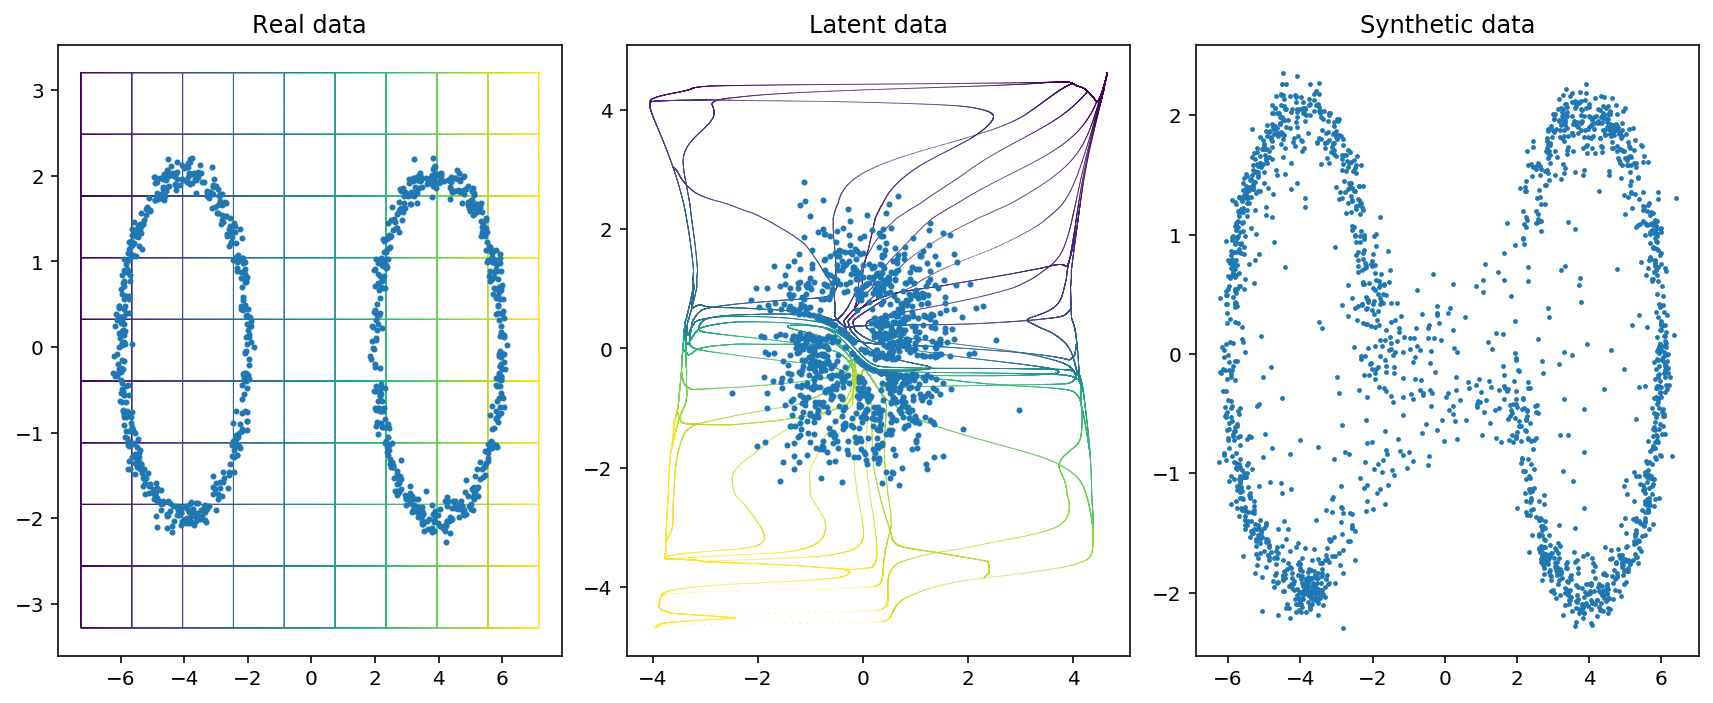

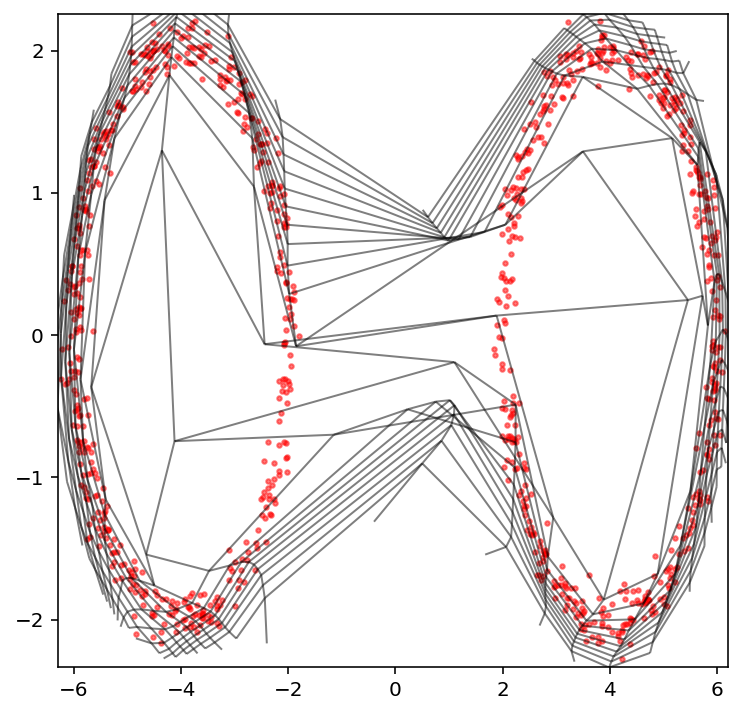

In [11]:
if like.x_dim == 2:
    plot_flow(samples, t)